Copyright (c) Microsoft Corporation. All rights reserved.  
Licensed under the MIT License.

![Impressions](https://PixelServer20190423114238.azurewebsites.net/api/impressions/MachineLearningNotebooks/how-to-use-azureml/deployment/onnx/onnx-inference-facial-expression-recognition-deploy.png)

# Facial Expression Recognition (FER+) using ONNX Runtime on Azure ML

This example shows how to deploy an image classification neural network using the Facial Expression Recognition ([FER](https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge/data)) dataset and Open Neural Network eXchange format ([ONNX](http://aka.ms/onnxdocarticle)) on the Azure Machine Learning platform. This tutorial will show you how to deploy a FER+ model from the [ONNX model zoo](https://github.com/onnx/models), use it to make predictions using ONNX Runtime Inference, and deploy it as a web service in Azure.

Throughout this tutorial, we will be referring to ONNX, a neural network exchange format used to represent deep learning models. With ONNX, AI developers can more easily move models between state-of-the-art tools (CNTK, PyTorch, Caffe, MXNet, TensorFlow) and choose the combination that is best for them. ONNX is developed and supported by a community of partners including Microsoft AI, Facebook, and Amazon. For more information, explore the [ONNX website](http://onnx.ai) and [open source files](https://github.com/onnx).

[ONNX Runtime](https://aka.ms/onnxruntime-python) is the runtime engine that enables evaluation of trained machine learning (Traditional ML and Deep Learning) models with high performance and low resource utilization. We use the CPU version of ONNX Runtime in this tutorial, but will soon be releasing an additional tutorial for deploying this model using ONNX Runtime GPU.

#### Tutorial Objectives:

1. Describe the FER+ dataset and pretrained Convolutional Neural Net ONNX model for Emotion Recognition, stored in the ONNX model zoo.
2. Deploy and run the pretrained FER+ ONNX model on an Azure Machine Learning instance
3. Predict labels for test set data points in the cloud using ONNX Runtime and Azure ML

## Prerequisites

### 1. Install Azure ML SDK and create a new workspace
If you are using an Azure Machine Learning Notebook VM, you are all set. Otherwise, please follow [Azure ML configuration notebook](../../../configuration.ipynb) to set up your environment.

### 2. Install additional packages needed for this Notebook
You need to install the popular plotting library `matplotlib`, the image manipulation library `opencv`, and the `onnx` library in the conda environment where Azure Maching Learning SDK is installed.

```sh
(myenv) $ pip install matplotlib onnx opencv-python
```

**Debugging tip**: Make sure that to activate your virtual environment (myenv) before you re-launch this notebook using the `jupyter notebook` comand. Choose the respective Python kernel for your new virtual environment using the `Kernel > Change Kernel` menu above. If you have completed the steps correctly, the upper right corner of your screen should state `Python [conda env:myenv]` instead of `Python [default]`.

### 3. Download sample data and pre-trained ONNX model from ONNX Model Zoo.

In the following lines of code, we download [the trained ONNX Emotion FER+ model and corresponding test data](https://github.com/onnx/models/tree/master/vision/body_analysis/emotion_ferplus) and place them in the same folder as this tutorial notebook. For more information about the FER+ dataset, please visit Microsoft Researcher Emad Barsoum's [FER+ source data repository](https://github.com/ebarsoum/FERPlus).

In [1]:
# urllib is a built-in Python library to download files from URLs

# Objective: retrieve the latest version of the ONNX Emotion FER+ model files from the
# ONNX Model Zoo and save it in the same folder as this tutorial

import urllib.request

onnx_model_url = "https://www.cntk.ai/OnnxModels/emotion_ferplus/opset_7/emotion_ferplus.tar.gz"

urllib.request.urlretrieve(onnx_model_url, filename="emotion_ferplus.tar.gz")

# the ! magic command tells our jupyter notebook kernel to run the following line of 
# code from the command line instead of the notebook kernel

# We use tar and xvcf to unzip the files we just retrieved from the ONNX model zoo

!tar xvzf emotion_ferplus.tar.gz

x emotion_ferplus/
x emotion_ferplus/model.onnx
x emotion_ferplus/test_data_set_0/
x emotion_ferplus/test_data_set_0/input_0.pb
x emotion_ferplus/test_data_set_0/output_0.pb
x emotion_ferplus/test_data_set_1/
x emotion_ferplus/test_data_set_1/input_0.pb
x emotion_ferplus/test_data_set_1/output_0.pb
x emotion_ferplus/test_data_set_2/
x emotion_ferplus/test_data_set_2/input_0.pb
x emotion_ferplus/test_data_set_2/output_0.pb


## Deploy a VM with your ONNX model in the Cloud

### Load Azure ML workspace

We begin by instantiating a workspace object from the existing workspace created earlier in the configuration notebook.

In [1]:
# Check core SDK version number
import azureml.core

print("SDK version:", azureml.core.VERSION)

SDK version: 1.0.85


In [3]:
from azureml.core import Workspace

ws = Workspace.from_config()
print(ws.name, ws.location, ws.resource_group, sep = '\n')

Note, we have launched a browser for you to login. For old experience with device code, use "az login --use-device-code"


Performing interactive authentication. Please follow the instructions on the terminal.


You have logged in. Now let us find all the subscriptions to which you have access...


Interactive authentication successfully completed.
onnx-pected-ws
southcentralus
onnx-pected-rg


### Registering your model with Azure ML

In [4]:
model_dir = "emotion_ferplus" # replace this with the location of your model files

# leave as is if it's in the same folder as this notebook

In [5]:
from azureml.core.model import Model

model = Model.register(model_path = model_dir + "/" + "model.onnx",
                       model_name = "onnx_emotion",
                       tags = {"onnx": "demo"},
                       description = "FER+ emotion recognition CNN from ONNX Model Zoo",
                       workspace = ws)

Registering model onnx_emotion


### Optional: Displaying your registered models

This step is not required, so feel free to skip it.

In [6]:
models = ws.models
for name, m in models.items():
    print("Name:", name,"\tVersion:", m.version, "\tDescription:", m.description, m.tags)

Name: onnx_emotion 	Version: 3 	Description: FER+ emotion recognition CNN from ONNX Model Zoo {'onnx': 'demo'}
Name: component_compliance 	Version: 2 	Description: None {}
Name: onnx_taxiFare 	Version: 1 	Description: Taxi Fare Pred {'onnx': 'demo'}
Name: OnnxMNIST 	Version: 4 	Description: CNN ONNX Model {}
Name: mnist_1 	Version: 1 	Description: MNIST image classification CNN from ONNX Model Zoo {'onnx': 'demo'}
Name: mnist 	Version: 1 	Description: None {}
Name: PyTorchMNIST 	Version: 1 	Description: CNN PyTorch Model {}
Name: sklearn_mnist 	Version: 1 	Description: None {}
Name: pi_estimate 	Version: 1 	Description: None {}


### ONNX FER+ Model Methodology

The image classification model we are using is pre-trained using Microsoft's deep learning cognitive toolkit, [CNTK](https://github.com/Microsoft/CNTK), from the [ONNX model zoo](http://github.com/onnx/models). The model zoo has many other models that can be deployed on cloud providers like AzureML without any additional training. To ensure that our cloud deployed model works, we use testing data from the well-known FER+ data set, provided as part of the [trained Emotion Recognition model](https://github.com/onnx/models/tree/master/vision/body_analysis/emotion_ferplus) in the ONNX model zoo.

The original Facial Emotion Recognition (FER) Dataset was released in 2013 by Pierre-Luc Carrier and Aaron Courville as part of a [Kaggle Competition](https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge/data), but some of the labels are not entirely appropriate for the expression. In the FER+ Dataset, each photo was evaluated by at least 10 croud sourced reviewers, creating a more accurate basis for ground truth. 

You can see the difference of label quality in the sample model input below. The FER labels are the first word below each image, and the FER+ labels are the second word below each image.

![](https://raw.githubusercontent.com/Microsoft/FERPlus/master/FER+vsFER.png)

***Input: Photos of cropped faces from FER+ Dataset***

***Task: Classify each facial image into its appropriate emotions in the emotion table***

```    emotion_table = {'neutral':0, 'happiness':1, 'surprise':2, 'sadness':3, 'anger':4, 'disgust':5, 'fear':6, 'contempt':7} ```

***Output: Emotion prediction for input image***


Remember, once the application is deployed in Azure ML, you can use your own images as input for the model to classify.

In [7]:
# for images and plots in this notebook
import matplotlib.pyplot as plt  

# display images inline
%matplotlib inline

### Model Description

The FER+ model from the ONNX Model Zoo is summarized by the graphic below. You can see the entire workflow of our pre-trained model in the following image from Barsoum et. al's paper ["Training Deep Networks for Facial Expression Recognition
with Crowd-Sourced Label Distribution"](https://arxiv.org/pdf/1608.01041.pdf), with our (64 x 64) input images and our output probabilities for each of the labels.

![](https://raw.githubusercontent.com/vinitra/FERPlus/master/emotion_model_img.png)

### Specify our Score and Environment Files

We are now going to deploy our ONNX Model on AML with inference in ONNX Runtime. We begin by writing a score.py file, which will help us run the model in our Azure ML virtual machine (VM), and then specify our environment by writing a yml file. You will also notice that we import the onnxruntime library to do runtime inference on our ONNX models (passing in input and evaluating out model's predicted output). More information on the API and commands can be found in the [ONNX Runtime documentation](https://aka.ms/onnxruntime).

### Write Score File

A score file is what tells our Azure cloud service what to do. After initializing our model using azureml.core.model, we start an ONNX Runtime inference session to evaluate the data passed in on our function calls.

In [8]:
%%writefile score.py
import json
import numpy as np
import onnxruntime
import sys
import os
import time

def init():
    global session, input_name, output_name
    model = os.path.join(os.getenv('AZUREML_MODEL_DIR'), 'model.onnx')
    session = onnxruntime.InferenceSession(model, None)
    input_name = session.get_inputs()[0].name
    output_name = session.get_outputs()[0].name 
    
def run(input_data):
    '''Purpose: evaluate test input in Azure Cloud using onnxruntime.
        We will call the run function later from our Jupyter Notebook 
        so our azure service can evaluate our model input in the cloud. '''

    try:
        # load in our data, convert to readable format
        data = np.array(json.loads(input_data)['data']).astype('float32')
        
        start = time.time()
        r = session.run([output_name], {input_name : data})
        end = time.time()
        
        result = emotion_map(postprocess(r[0]))
        
        result_dict = {"result": result,
                      "time_in_sec": [end - start]}
    except Exception as e:
        result_dict = {"error": str(e)}
    
    return json.dumps(result_dict)

def emotion_map(classes, N=1):
    """Take the most probable labels (output of postprocess) and returns the 
    top N emotional labels that fit the picture."""
    
    emotion_table = {'neutral':0, 'happiness':1, 'surprise':2, 'sadness':3, 
                     'anger':4, 'disgust':5, 'fear':6, 'contempt':7}
    
    emotion_keys = list(emotion_table.keys())
    emotions = []
    for i in range(N):
        emotions.append(emotion_keys[classes[i]])
    return emotions

def softmax(x):
    """Compute softmax values (probabilities from 0 to 1) for each possible label."""
    x = x.reshape(-1)
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)

def postprocess(scores):
    """This function takes the scores generated by the network and 
    returns the class IDs in decreasing order of probability."""
    prob = softmax(scores)
    prob = np.squeeze(prob)
    classes = np.argsort(prob)[::-1]
    return classes

Writing score.py


### Write Environment File

In [9]:
from azureml.core.conda_dependencies import CondaDependencies 

myenv = CondaDependencies.create(pip_packages=["numpy", "onnxruntime", "azureml-core"])

with open("myenv.yml","w") as f:
    f.write(myenv.serialize_to_string())

### Setup inference configuration

In [10]:
from azureml.core.model import InferenceConfig

inference_config = InferenceConfig(runtime= "python", 
                                   entry_script="score.py",
                                   conda_file="myenv.yml",
                                   extra_docker_file_steps = "Dockerfile")

### Deploy the model

In [11]:
from azureml.core.webservice import AciWebservice

aciconfig = AciWebservice.deploy_configuration(cpu_cores = 1, 
                                               memory_gb = 1, 
                                               tags = {'demo': 'onnx'}, 
                                               description = 'ONNX for emotion recognition model')

The following cell will likely take a few minutes to run as well.

In [12]:
aci_service_name = 'onnx-demo-emotion'
print("Service", aci_service_name)
aci_service = Model.deploy(ws, aci_service_name, [model], inference_config, aciconfig)
aci_service.wait_for_deployment(True)
print(aci_service.state)

Service onnx-demo-emotion
Creating image
Running..................................
Succeeded
Image creation operation finished for image onnx-demo-emotion:1, operation "Succeeded"
Running.........................
Succeeded
ACI service creation operation finished, operation "Succeeded"
Healthy


In [13]:
if aci_service.state != 'Healthy':
    # run this command for debugging.
    print(aci_service.get_logs())

    # If your deployment fails, make sure to delete your aci_service before trying again!
    # aci_service.delete()

### Success!

If you've made it this far, you've deployed a working VM with a facial emotion recognition model running in the cloud using Azure ML. Congratulations!

Let's see how well our model deals with our test images.

## Testing and Evaluation

### Useful Helper Functions

We preprocess and postprocess our data (see score.py file) using the helper functions specified in the [ONNX FER+ Model page in the Model Zoo repository](https://github.com/onnx/models/tree/master/vision/body_analysis/emotion_ferplus).

In [14]:
def emotion_map(classes, N=1):
    """Take the most probable labels (output of postprocess) and returns the 
    top N emotional labels that fit the picture."""
    
    emotion_table = {'neutral':0, 'happiness':1, 'surprise':2, 'sadness':3, 
                     'anger':4, 'disgust':5, 'fear':6, 'contempt':7}
    
    emotion_keys = list(emotion_table.keys())
    emotions = []
    for c in range(N):
        emotions.append(emotion_keys[classes[c]])
    return emotions

def softmax(x):
    """Compute softmax values (probabilities from 0 to 1) for each possible label."""
    x = x.reshape(-1)
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)

def postprocess(scores):
    """This function takes the scores generated by the network and 
    returns the class IDs in decreasing order of probability."""
    prob = softmax(scores)
    prob = np.squeeze(prob)
    classes = np.argsort(prob)[::-1]
    return classes

### Load Test Data

These are already in your directory from your ONNX model download (from the model zoo).

Notice that our Model Zoo files have a .pb extension. This is because they are [protobuf files (Protocol Buffers)](https://developers.google.com/protocol-buffers/docs/pythontutorial), so we need to read in our data through our ONNX TensorProto reader into a format we can work with, like numerical arrays.

In [16]:
# to manipulate our arrays
import numpy as np 

# read in test data protobuf files included with the model
import onnx
from onnx import numpy_helper

# to use parsers to read in our model/data
import json
import os

test_inputs = []
test_outputs = []

# read in 3 testing images from .pb files
test_data_size = 3

for num in np.arange(test_data_size):
    input_test_data = os.path.join(model_dir, 'test_data_set_{0}'.format(num), 'input_0.pb')
    output_test_data = os.path.join(model_dir, 'test_data_set_{0}'.format(num), 'output_0.pb')
    
    # convert protobuf tensors to np arrays using the TensorProto reader from ONNX
    tensor = onnx.TensorProto()
    with open(input_test_data, 'rb') as f:
        tensor.ParseFromString(f.read())
    
    input_data = numpy_helper.to_array(tensor)
    test_inputs.append(input_data)
    
    with open(output_test_data, 'rb') as f:
        tensor.ParseFromString(f.read())
    
    output_data = numpy_helper.to_array(tensor)
    output_processed = emotion_map(postprocess(output_data[0]))[0]
    test_outputs.append(output_processed)

### Show some sample images
We use `matplotlib` to plot 3 test images from the dataset.

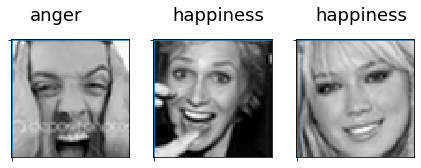

In [17]:
plt.figure(figsize = (20, 20))
for test_image in np.arange(3):
    test_inputs[test_image].reshape(1, 64, 64)
    plt.subplot(1, 8, test_image+1)
    plt.axhline('')
    plt.axvline('')
    plt.text(x = 10, y = -10, s = test_outputs[test_image], fontsize = 18)
    plt.imshow(test_inputs[test_image].reshape(64, 64), cmap = plt.cm.gray)
plt.show()

### Run evaluation / prediction

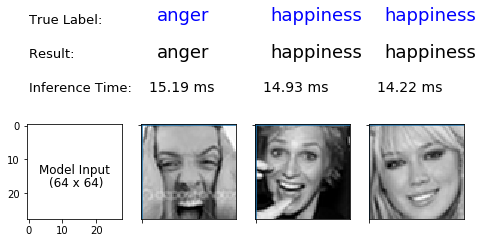

In [18]:
plt.figure(figsize = (16, 6), frameon=False)
plt.subplot(1, 8, 1)

plt.text(x = 0, y = -30, s = "True Label: ", fontsize = 13, color = 'black')
plt.text(x = 0, y = -20, s = "Result: ", fontsize = 13, color = 'black')
plt.text(x = 0, y = -10, s = "Inference Time: ", fontsize = 13, color = 'black')
plt.text(x = 3, y = 14, s = "Model Input", fontsize = 12, color = 'black')
plt.text(x = 6, y = 18, s = "(64 x 64)", fontsize = 12, color = 'black')
plt.imshow(np.ones((28,28)), cmap=plt.cm.Greys)    


for i in np.arange(test_data_size):
    
    input_data = json.dumps({'data': test_inputs[i].tolist()})

    # predict using the deployed model
    r = json.loads(aci_service.run(input_data))
    
    if "error" in r:
        print(r['error'])
        break
        
    result = r['result'][0]
    time_ms = np.round(r['time_in_sec'][0] * 1000, 2)
    
    ground_truth = test_outputs[i]
    
    # compare actual value vs. the predicted values:
    plt.subplot(1, 8, i+2)
    plt.axhline('')
    plt.axvline('')

    # use different color for misclassified sample
    font_color = 'red' if ground_truth != result else 'black'
    clr_map = plt.cm.Greys if ground_truth != result else plt.cm.gray

    # ground truth labels are in blue
    plt.text(x = 10, y = -70, s = ground_truth, fontsize = 18, color = 'blue')
    
    # predictions are in black if correct, red if incorrect
    plt.text(x = 10, y = -45, s = result, fontsize = 18, color = font_color)
    plt.text(x = 5, y = -22, s = str(time_ms) + ' ms', fontsize = 14, color = font_color)

    
    plt.imshow(test_inputs[i].reshape(64, 64), cmap = clr_map)

plt.show()

### Try classifying your own images!

In [20]:
# Preprocessing functions take your image and format it so it can be passed
# as input into our ONNX model

import cv2

def rgb2gray(rgb):
    """Convert the input image into grayscale"""
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

def resize_img(img_to_resize):
    """Resize image to FER+ model input dimensions"""
    r_img = cv2.resize(img_to_resize, dsize=(64, 64), interpolation=cv2.INTER_AREA)
    r_img.resize((1, 1, 64, 64))
    return r_img

def preprocess(img_to_preprocess):
    """Resize input images and convert them to grayscale."""
    if img_to_preprocess.shape == (64, 64):
        img_to_preprocess.resize((1, 1, 64, 64))
        return img_to_preprocess
    
    grayscale = rgb2gray(img_to_preprocess)
    processed_img = resize_img(grayscale)
    return processed_img

Old Dimensions:  (792, 800, 3)
New Dimensions:  (1, 1, 64, 64)


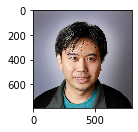

In [21]:
# Replace the following string with your own path/test image
# Make sure your image is square and the dimensions are equal (i.e. 100 * 100 pixels or 28 * 28 pixels)

# Any PNG or JPG image file should work
# Make sure to include the entire path with // instead of /

# e.g. your_test_image = "C:/Users/vinitra.swamy/Pictures/face.png"

your_test_image = "rondagdag.jpg"

import matplotlib.image as mpimg

if your_test_image != "<path to file>":
    img = mpimg.imread(your_test_image)
    plt.subplot(1,3,1)
    plt.imshow(img, cmap = plt.cm.Greys)
    print("Old Dimensions: ", img.shape)
    img = preprocess(img)
    print("New Dimensions: ", img.shape)
else:
    img = None

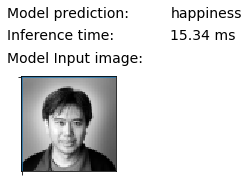

In [22]:
if img is None:
    print("Add the path for your image data.")
else:
    input_data = json.dumps({'data': img.tolist()})

    try:
        r = json.loads(aci_service.run(input_data))
        result = r['result'][0]
        time_ms = np.round(r['time_in_sec'][0] * 1000, 2)
    except KeyError as e:
        print(str(e))

    plt.figure(figsize = (16, 6))
    plt.subplot(1,8,1)
    plt.axhline('')
    plt.axvline('')
    plt.text(x = -10, y = -40, s = "Model prediction: ", fontsize = 14)
    plt.text(x = -10, y = -25, s = "Inference time: ", fontsize = 14)
    plt.text(x = 100, y = -40, s = str(result), fontsize = 14)
    plt.text(x = 100, y = -25, s = str(time_ms) + " ms", fontsize = 14)
    plt.text(x = -10, y = -10, s = "Model Input image: ", fontsize = 14)
    plt.imshow(img.reshape((64, 64)), cmap = plt.cm.gray)    
     

In [23]:
# remember to delete your service after you are done using it!

aci_service.delete()

## Conclusion

Congratulations!

In this tutorial, you have:
- familiarized yourself with ONNX Runtime inference and the pretrained models in the ONNX model zoo
- understood a state-of-the-art convolutional neural net image classification model (FER+ in ONNX) and deployed it in the Azure ML cloud
- ensured that your deep learning model is working perfectly (in the cloud) on test data, and checked it against some of your own!

Next steps:
- If you have not already, check out another interesting ONNX/AML application that lets you set up a state-of-the-art [handwritten image classification model (MNIST)](https://github.com/Azure/MachineLearningNotebooks/blob/master/how-to-use-azureml/deployment/onnx/onnx-inference-mnist-deploy.ipynb) in the cloud! This tutorial deploys a pre-trained ONNX Computer Vision model for handwritten digit classification in an Azure ML virtual machine.
- Keep an eye out for an updated version of this tutorial that uses ONNX Runtime GPU.
- Contribute to our [open source ONNX repository on github](http://github.com/onnx/onnx) and/or add to our [ONNX model zoo](http://github.com/onnx/models)